# Regression

In this notebook we demonstate how to fit a Gaussian process regression model.

In [11]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
from jax import jit
from jax.config import config
from utils import clean_legend

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
plt.style.use('./gpjax.mplstyle')
cols = mpl.rcParams['axes.prop_cycle'].by_key()['color']

## Dataset

With the necessary modules imported, we simulate a dataset
$\mathcal{D} = (\boldsymbol{x}, \boldsymbol{y}) = \{(x_i, y_i)\}_{i=1}^{100}$ with inputs $\boldsymbol{x}$
sampled uniformly on $(-3., 3)$ and corresponding independent noisy outputs

$$\boldsymbol{y} \sim \mathcal{N} \left(\sin(4\boldsymbol{x}) + \cos(2 \boldsymbol{x}), \textbf{I} * 0.3^2 \right).$$

We store our data $\mathcal{D}$ as a GPJax `Dataset` and create test inputs and labels
for later.

In [4]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

To better understand what we have simulated, we plot both the underlying latent
function and the observed data that is subject to Gaussian noise.

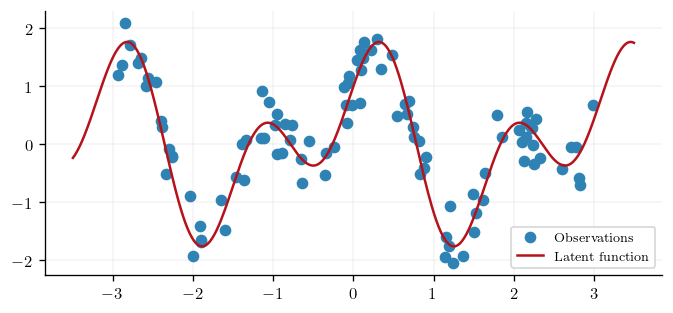

In [8]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")

Our aim in this tutorial will be to reconstruct the latent function from our noisy
observations $\mathcal{D}$ via Gaussian process regression. We begin by defining a
Gaussian process prior in the next section.

## Defining the prior

A zero-mean Gaussian process (GP) places a prior distribution over real-valued
functions $f(\cdot)$ where
$f(\boldsymbol{x}) \sim \mathcal{N}(0, \mathbf{K}_{\boldsymbol{x}\boldsymbol{x}})$
for any finite collection of inputs $\boldsymbol{x}$.

Here $\mathbf{K}_{\boldsymbol{x}\boldsymbol{x}}$ is the Gram matrix generated by a
user-specified symmetric, non-negative definite kernel function $k(\cdot, \cdot')$
with $[\mathbf{K}_{\boldsymbol{x}\boldsymbol{x}}]_{i, j} = k(x_i, x_j)$.
The choice of kernel function is critical as, among other things, it governs the
smoothness of the outputs that our GP can generate.

For simplicity, we consider a radial basis function (RBF) kernel:
$$k(x, x') = \sigma^2 \exp\left(-\frac{\lVert x - x' \rVert_2^2}{2 \ell^2}\right).$$

On paper a GP is written as $f(\cdot) \sim \mathcal{GP}(\textbf{0}, k(\cdot, \cdot'))$,
we can reciprocate this process in GPJax via defining a `Prior` with our chosen `RBF`
kernel.

In [9]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)


The above construction forms the foundation for GPJax's models. Moreover, the GP prior
we have just defined can be represented by a
[TensorFlow Probability](https://www.tensorflow.org/probability/api_docs/python/tfp/substrates/jax)
multivariate Gaussian distribution. Such functionality enables trivial sampling, and
the evaluation of the GP's mean and covariance .

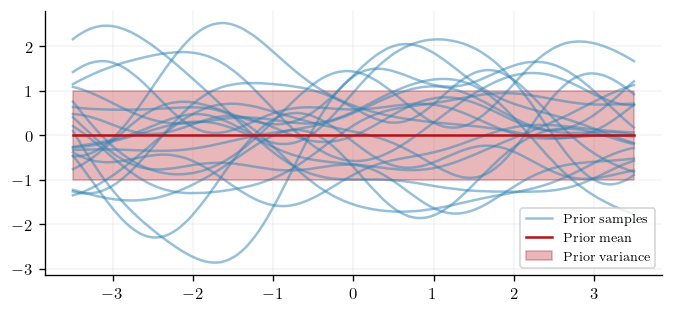

In [13]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")
ax = clean_legend(ax)

## Constructing the posterior

Having defined our GP, we proceed to define a description of our data
$\mathcal{D}$ conditional on our knowledge of $f(\cdot)$ --- this is exactly the
notion of a likelihood function $p(\mathcal{D} | f(\cdot))$. While the choice of
likelihood is a critical in Bayesian modelling, for simplicity we consider a
Gaussian with noise parameter $\alpha$
$$p(\mathcal{D} | f(\cdot)) = \mathcal{N}(\boldsymbol{y}; f(\boldsymbol{x}), \textbf{I} \alpha^2).$$
This is defined in GPJax through calling a `Gaussian` instance.

In [14]:
likelihood = gpx.Gaussian(num_datapoints=D.n)

The posterior is proportional to the prior multiplied by the likelihood, written as

  $$ p(f(\cdot) | \mathcal{D}) \propto p(f(\cdot)) * p(\mathcal{D} | f(\cdot)). $$

Mimicking this construct, the posterior is established in GPJax through the `*` operator.

In [15]:
posterior = prior * likelihood

<!-- ## Hyperparameter optimisation

Our kernel is parameterised by a length-scale $\ell^2$ and variance parameter
$\sigma^2$, while our likelihood controls the observation noise with $\alpha^2$.
Using Jax's automatic differentiation module, we can take derivatives of  -->

## Parameter state

As outlined in the [PyTrees](https://jax.readthedocs.io/en/latest/pytrees.html)
documentation, parameters are contained within the model and for the leaves of the
PyTree. Consequently, in this particular model, we have three parameters: the
kernel lengthscale, kernel variance and the observation noise variance. Whilst
we have initialised each of these to 1, we can learn Type 2 MLEs for each of
these parameters by optimising the marginal log-likelihood (MLL).

In [16]:
negative_mll = jit(gpx.objectives.ConjugateMLL(negative=True))
negative_mll(posterior, train_data=D)

Array(124.80517341, dtype=float64)

Since most optimisers (including here) minimise a given function, we have realised
the negative marginal log-likelihood and just-in-time (JIT) compiled this to
accelerate training.

We can now define an optimiser with `optax`. For this example we'll use the `adam`
optimiser.

In [17]:
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_mll,
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=500,
    safe=True
)

/Users/tompinder/Development/JaxGPDevs/GPJax/gpjax/fit.py:190: UserWarning: Objective is jit-compiled. Please ensure that the objective is of type gpjax.Objective.
  warn("Objective is jit-compiled. Please ensure that the objective is of type gpjax.Objective.")


  0%|          | 0/500 [00:00<?, ?it/s]

The calling of `fit` returns two objects: the optimised posterior and a history of
training losses. We can plot the training loss to see how the optimisation has
progressed.

[Text(0.5, 0, 'Training iteration'),
 Text(0, 0.5, 'Negative marginal log likelihood')]

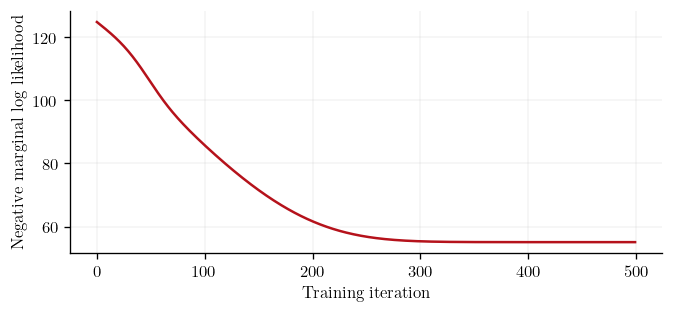

In [19]:
fig, ax = plt.subplots()
ax.plot(history, color=cols[1])
ax.set(xlabel='Training iteration', ylabel='Negative marginal log likelihood')

## Prediction

Equipped with the posterior and a set of optimised hyperparameter values, we are now
in a position to query our GP's predictive distribution at novel test inputs. To do
this, we use our defined `posterior` and `likelihood` at our test inputs to obtain
the predictive distribution as a `Distrax` multivariate Gaussian upon which `mean`
and `stddev` can be used to extract the predictive mean and standard deviatation.

In [20]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

With the predictions and their uncertainty acquired, we illustrate the GP's
performance at explaining the data $\mathcal{D}$ and recovering the underlying
latent function of interest.

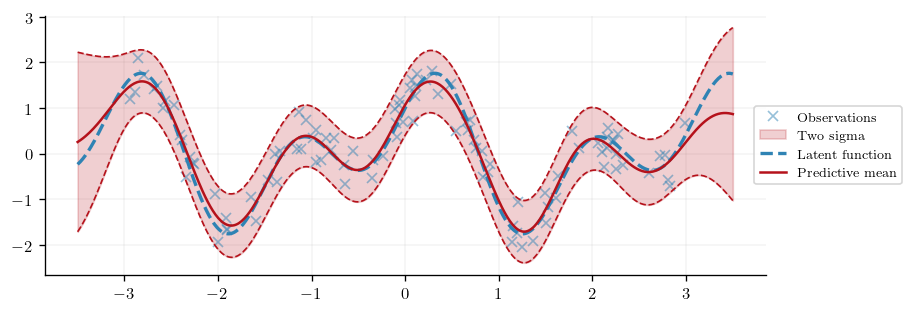

In [22]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 *predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1]
)
ax.plot(
    xtest,
    predictive_mean + 2 *predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1]
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc='center left', bbox_to_anchor=(0.975, 0.5))

## System configuration

In [ ]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder & Daniel Dodd'

Author: Thomas Pinder & Daniel Dodd

Last updated: Thu Apr 20 2023

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.11.0

gpjax     : 0.5.9.post47.dev0+4f510ee
jax       : 0.4.8
matplotlib: 3.7.1
optax     : 0.1.4

Watermark: 2.3.1

